In [1]:
%matplotlib inline
## %gui wx ## if we use mayavi !

import matplotlib.pyplot as plt
from matplotlib import cm

from badlands import meshtools 
from badlands import TreMesh
from badlands import HeightMesh
from badlands import SurfaceProcessMesh

import numpy as np
import scipy.interpolate as interpolate

Origin =  0.0 0.0 Radius =  5.0 Aspect =  1.0


<matplotlib.colorbar.Colorbar instance at 0x10b1137e8>

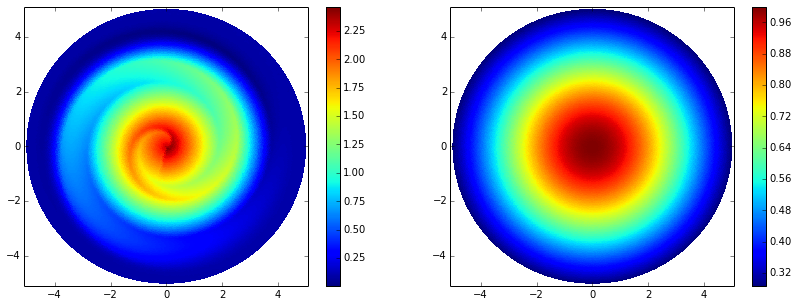

In [2]:
x1, y1, bmask, inverse_bmask = meshtools.elliptical_mesh(-5.0, 5.0, -5.0,  5.0, 0.05, 0.05, 25000, 250 )
x5,y5 = meshtools.lloyd_mesh_improvment(x1,y1, bmask, 5)
r5 = np.sqrt(x5**2 + y5**2)
z5 = np.exp(-(1.2* r5 / 5.0)**12) + 0.0001 * np.random.rand(len(x5))
rainfall = np.exp(-0.05*r5**2)


theta = np.linspace(0.0000001, 10.0*np.pi, 2500)
s1 = 0.4 * theta 
s2 = 0.3 * theta 
x1 = s1 * np.cos(theta)
y1 = s1 * np.sin(theta)
x2 = s2 * np.cos(theta)
y2 = s2 * np.sin(theta)

h2 = 1.0 - s1 / 5.0
h1 = h2.copy() + 0.1

x = np.hstack( [x1,x2] )
y = np.hstack( [y1,y2] )
h = np.hstack( [h1,h2] )

points = np.transpose(np.array( [x,y] ))
interp = interpolate.LinearNDInterpolator(points, h)
newpoints = np.transpose(np.array([x5,y5]))
h5 = interp(newpoints)
h5 = h5*z5

h5 -= h5.min()
h5 *= 2.5 / h5.max()

h5 += 0.001 * np.random.rand(len(h5))

fig, (plot1, plot2) = plt.subplots(1,2)
fig.set_size_inches(14,5)

plot1.set_xlim(-5.1, 5.1)
plot1.set_ylim(-5.1, 5.1)
plot2.set_xlim(-5.1, 5.1)
plot2.set_ylim(-5.1, 5.1)

hc1 = plot1.tripcolor(x5,y5,h5)
hc2 = plot2.tripcolor(x5,y5,rainfall)

fig.colorbar(hc1, ax=plot1)
fig.colorbar(hc2, ax=plot2)

In [10]:
# r5 = h5**2 # Rainfall pattern


mesh5 = SurfaceProcessMesh(x5, y5, h5, rainfall, None, bmask, verbose=False)
mesh5.height = mesh5.handle_low_points2(0.0, 5)  
mesh5.height = mesh5.local_area_smoothing(mesh5.height, its=5, centre_weight=0.75)
mesh5.update_height(mesh5.height)
mesh5.update_surface_processes()


depo min/max, mean 0.0 294.040881081 0.0145406429177
depo min/max, mean 0.0 281.700816505 0.0139304132383
depo min/max, mean 0.0 293.041816767 0.0144912380955


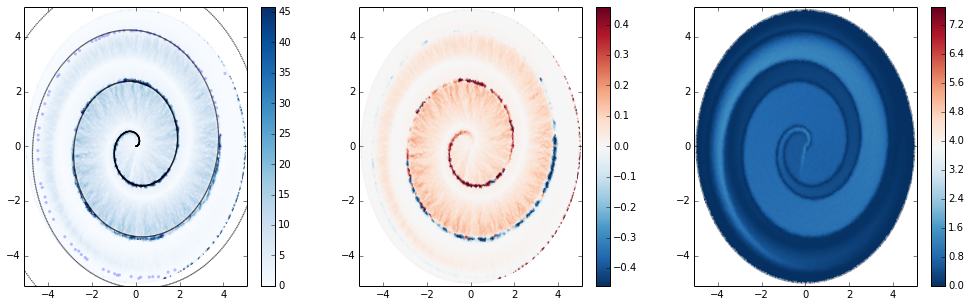

In [11]:
# This is how to obtain the erosion rate / deposition rate 

# mesh5.update_height(z5)
# mesh5.update_surface_processes()

# erosion_rate, deposition_rate, stream_power = mesh5.stream_power_erosion_deposition_rate(0.01, 0, 0, 0, 0)
# erosion_deposition_rate = erosion_rate - deposition_rate

erosion_rate, deposition_rate, stream_power = \
         mesh5.stream_power_erosion_deposition_rate2(efficiency=0.01, 
                                                    smooth_power=0, 
                                                    smooth_low_points=2, 
                                                    smooth_erosion_rate=0, 
                                                    smooth_deposition_rate=2, 
                                                    smooth_operator=mesh5.downhill_smoothing,
                                                    centre_weight_u=0.75, centre_weight=0.5)

    
    
erosion_deposition_rate = erosion_rate - deposition_rate

# flat_spots = mesh5.identify_flat_spots()
# smoothed_deposition_rate = deposition_rate.copy()
# smoothed_deposition_rate[np.invert(flat_spots)] = 0.0
# smoothed_deposition_rate = mesh5.local_area_smoothing(smoothed_deposition_rate, its=2, centre_weight=0.5)
# deposition_rate[flat_spots] = smoothed_deposition_rate[flat_spots]
     
erosion_deposition_rate2 = erosion_rate - deposition_rate


print "depo min/max, mean", deposition_rate.min(), deposition_rate.sum(), deposition_rate.mean()

deposition_rate2 = mesh5.streamwise_smoothing(deposition_rate, 5)

print "depo min/max, mean", deposition_rate2.min(), deposition_rate2.sum(), deposition_rate2.mean()

deposition_rate3 = mesh5.local_area_smoothing(deposition_rate, 5, centre_weight=0.5)
print "depo min/max, mean", deposition_rate3.min(), deposition_rate3.sum(), deposition_rate3.mean()

not_so_low_points = []
for node in mesh5.low_points:
    if mesh5.height[node] > 0.005 * mesh5.height.max():
        not_so_low_points.append(node)

fig, (plot1, plot2, plot3) = plt.subplots(1,3)
fig.set_size_inches(17,5)

plot1.set_xlim(-5.1, 5.1)
plot1.set_ylim(-5.1, 5.1)
plot2.set_xlim(-5.1, 5.1)
plot2.set_ylim(-5.1, 5.1)
plot3.set_xlim(-5.1, 5.1)
plot3.set_ylim(-5.1, 5.1)


maxED  =    erosion_deposition_rate[bmask].max() / 5.0 
maxPWR =    stream_power[bmask].max() / 5.0
#maxCUM =    cumulative_rain[bmask].max() / 2.0

sm1 = mesh5.add_node_data_to_plot(plot1, stream_power, vmin=0.0, vmax=maxPWR, cmap=cm.Blues,  shading="gouraud")
#plot1.tricontour(mesh5.x, mesh5.y, mesh5.tri.simplices.copy(), mesh5.height, (0.001, 0.01, 0.1, 0.99))
#sm1b = mesh5.add_node_data_to_plot(plot1, mesh5.rainfall_pattern, cmap=cm.BrBG, shading="gouraud", alpha=0.1)
plot1.scatter(mesh5.x[mesh5.low_points], mesh5.y[mesh5.low_points],10, marker="o", alpha=0.25, linewidth=0.0)
plot1.scatter(x2,y2, s=0.1)



fig.colorbar(sm1, ax=plot1)

sm2 = mesh5.add_node_data_to_plot(plot2, erosion_deposition_rate, vmin=-maxED, vmax=maxED, cmap=cm.RdBu_r,  shading="gouraud") #, vmax=maxDR)
fig.colorbar(sm2, ax=plot2)

sm3 = mesh5.add_node_data_to_plot(plot3, mesh5.slope, cmap=cm.RdBu_r,  shading="gouraud") #, vmax=maxDR)
fig.colorbar(sm3, ax=plot3)

fig.savefig("ziggurat-power.png", dpi=300)
#plt.close()
    


In [5]:
%%sh

open ziggurat-power.png

In [13]:
# Decomposed mesh 
    
# Quadrant 1 - 4 

# Could make this a submesh class with a condition !

mesh5Identifier = np.zeros(mesh5.tri.npoints)


meshQ1nodes      = np.where( np.logical_and(x5 < 0.0,  y5 < 0.0)  ) 
meshQ1shadow     = np.where( np.logical_and(x5 < 0.2,  y5 < 0.2) ) 
meshQ1shadowOnly = np.setdiff1d( meshQ1shadow, meshQ1nodes)
mesh5Identifier[meshQ1nodes] = 1

xq1 = mesh5.x[meshQ1nodes]
yq1 = mesh5.y[meshQ1nodes]
hq1 = mesh5.height[meshQ1nodes]
rq1 = mesh5.rainfall_pattern[meshQ1nodes]
bq1 = mesh5.bmask[meshQ1nodes]

# For computation we don't need this mesh, only the node list 
meshQ1 = SurfaceProcessMesh(xq1, yq1, hq1, rq1, None, bq1, verbose=False)

xq1 = mesh5.x[meshQ1shadow]
yq1 = mesh5.y[meshQ1shadow]
hq1 = mesh5.height[meshQ1shadow]
rq1 = mesh5.rainfall_pattern[meshQ1shadow]
bq1 = mesh5.bmask[meshQ1shadow]

meshQ1s = SurfaceProcessMesh(xq1, yq1, hq1, rq1, None, bq1,  verbose=False)

## Q2

meshQ2nodes   = np.where( np.logical_and(x5 >  0.0,  y5 <  0.0)  ) 
meshQ2shadow  = np.where( np.logical_and(x5 > -0.2,  y5 <  0.2) ) 
meshQ2shadowOnly = np.setdiff1d( meshQ2shadow, meshQ2nodes)
mesh5Identifier[meshQ2nodes] = 2

xq1 = mesh5.x[meshQ2nodes]
yq1 = mesh5.y[meshQ2nodes]
hq1 = mesh5.height[meshQ2nodes]
rq1 = mesh5.rainfall_pattern[meshQ2nodes]
bq1 = mesh5.bmask[meshQ2nodes]

# For computation we don't need this mesh, only the node list 
meshQ2 = SurfaceProcessMesh(xq1, yq1, hq1, rq1, None, bq1, verbose=False)

xq1 = mesh5.x[meshQ2shadow]
yq1 = mesh5.y[meshQ2shadow]
hq1 = mesh5.height[meshQ2shadow]
rq1 = mesh5.rainfall_pattern[meshQ2shadow]
bq1 = mesh5.bmask[meshQ2shadow]

meshQ2s = SurfaceProcessMesh(xq1, yq1, hq1, rq1, None, bq1, verbose=False)

## Q3

meshQ3nodes   = np.where( np.logical_and(x5 >  0.0,  y5 >  0.0)  ) 
meshQ3shadow  = np.where( np.logical_and(x5 > -0.2,  y5 > -0.2) ) 
meshQ3shadowOnly = np.setdiff1d( meshQ3shadow, meshQ3nodes)
mesh5Identifier[meshQ3nodes] = 3


xq1 = mesh5.x[meshQ3nodes]
yq1 = mesh5.y[meshQ3nodes]
hq1 = mesh5.height[meshQ3nodes]
rq1 = mesh5.rainfall_pattern[meshQ3nodes]
bq1 = mesh5.bmask[meshQ3nodes]

# For computation we don't need this mesh, only the node list 
meshQ3 = SurfaceProcessMesh(xq1, yq1, hq1, rq1, None, bq1, verbose=False)

xq1 = mesh5.x[meshQ3shadow]
yq1 = mesh5.y[meshQ3shadow]
hq1 = mesh5.height[meshQ3shadow]
rq1 = mesh5.rainfall_pattern[meshQ3shadow]
bq1 = mesh5.bmask[meshQ3shadow]

meshQ3s = SurfaceProcessMesh(xq1, yq1, hq1, rq1, None, bq1, verbose=False)

## Q4

meshQ4nodes   = np.where( np.logical_and(x5 <  0.0,  y5 >  0.0)  ) 
meshQ4shadow  = np.where( np.logical_and(x5 <  0.2,  y5 > -0.2) ) 
meshQ4shadowOnly = np.setdiff1d( meshQ4shadow, meshQ4nodes)
mesh5Identifier[meshQ4nodes] = 4

xq1 = mesh5.x[meshQ4nodes]
yq1 = mesh5.y[meshQ4nodes]
hq1 = mesh5.height[meshQ4nodes]
rq1 = mesh5.rainfall_pattern[meshQ4nodes]
bq1 = mesh5.bmask[meshQ4nodes]

# For computation we don't need this mesh, only the node list 
meshQ4 = SurfaceProcessMesh(xq1, yq1, hq1, rq1, None, bq1, verbose=False)

xq1 = mesh5.x[meshQ4shadow]
yq1 = mesh5.y[meshQ4shadow]
hq1 = mesh5.height[meshQ4shadow]
rq1 = mesh5.rainfall_pattern[meshQ4shadow]
bq1 = mesh5.bmask[meshQ4shadow]

meshQ4s = SurfaceProcessMesh(xq1, yq1, hq1, rq1,  None, bq1, verbose=False)


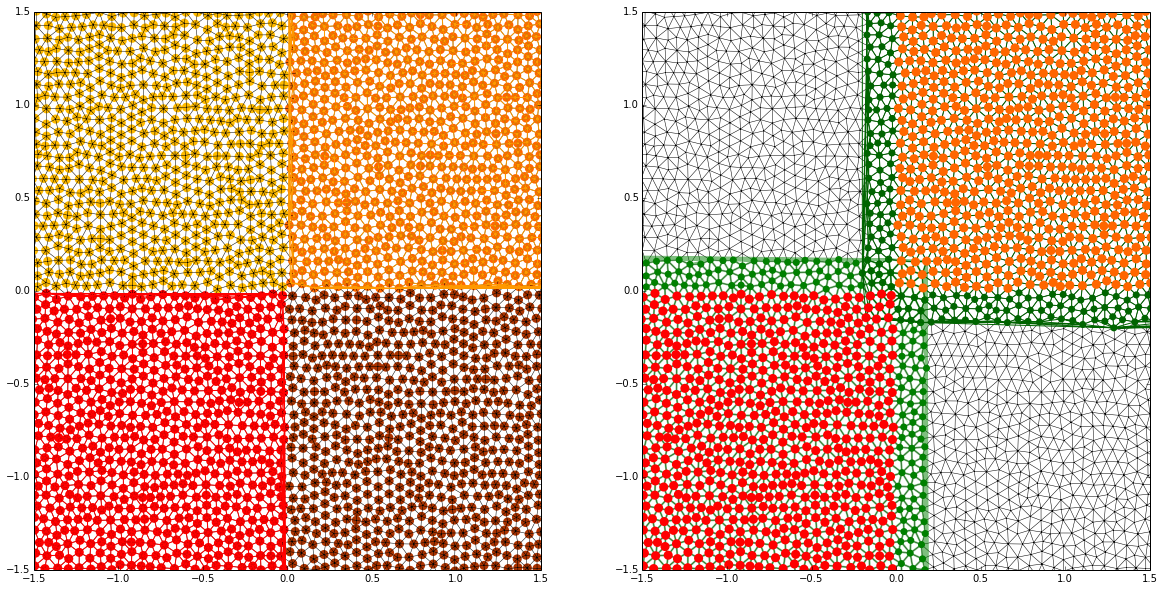

In [6]:
fig, (plot1,plot2) = plt.subplots(1,2)
fig.set_size_inches(20,10)

lim = 1.5

plot1.set_xlim(-lim, lim)
plot1.set_ylim(-lim, lim)
plot2.set_xlim(-lim, lim)
plot2.set_ylim(-lim, lim)

plot1.triplot(mesh5.x, mesh5.y, mesh5.tri.simplices, marker=None, linewidth=0.5)
plot1.triplot(meshQ1.x, meshQ1.y, meshQ1.tri.simplices, marker=None, color="Red", linewidth=1.0)
plot1.triplot(meshQ3.x, meshQ3.y, meshQ3.tri.simplices, marker=None, color="#FF9900", linewidth=1.0)
plot1.scatter(meshQ1.x, meshQ1.y, s=50.0, marker='o', linewidth=2, color="Red")
plot1.scatter(meshQ2.x, meshQ2.y, s=50.0, marker='o', linewidth=2, color="#AA3300")
plot1.scatter(meshQ3.x, meshQ3.y, s=50.0, marker='o', linewidth=2, color="#FF6600")
plot1.scatter(meshQ4.x, meshQ4.y, s=50.0, marker='o', linewidth=2, color="#FFBB00")
plot2.triplot(mesh5.x, mesh5.y, mesh5.tri.simplices, marker=None, linewidth=0.5, zorder=0)
plot2.triplot(meshQ1s.x, meshQ1s.y, meshQ1s.tri.simplices, marker=None, color="Green", linewidth=2.0, alpha=0.5,zorder=1)
plot2.scatter(meshQ1s.x, meshQ1s.y, s=50.0, marker='o', linewidth=0.0, color="Green", zorder=1)
plot2.triplot(meshQ3s.x, meshQ3s.y, meshQ3s.tri.simplices, marker=None, color="DarkGreen", linewidth=1.0, zorder=1)
plot2.scatter(meshQ3s.x, meshQ3s.y, s=50.0, marker='o', linewidth=0.0, color="DarkGreen", zorder=1)
plot2.scatter(meshQ3.x, meshQ3.y, s=50.0, marker='o', linewidth=2, color="#FF6600", zorder=2)
plot2.scatter(meshQ1.x, meshQ1.y, s=50.0, marker='o', linewidth=2, color="Red",zorder=2)


In [7]:
#%%timeit
# Matrix-vector multiplication on the sub meshes !!

vector = mesh5.area.copy() # say
result = np.zeros(mesh5.tri.npoints)
target = mesh5.downhillMat.dot(vector)

# load the RHS with only the values in the local mesh but
# into the larger mesh which also has the shadow nodes

vecQ1 = np.where(mesh5Identifier == 1, vector, 0.0)[meshQ1shadow]
resQ1 = meshQ1s.downhillMat.dot(vecQ1)

vecQ2 = np.where(mesh5Identifier == 2, vector, 0.0)[meshQ2shadow]
resQ2 = meshQ2s.downhillMat.dot(vecQ2)

vecQ3 = np.where(mesh5Identifier == 3, vector, 0.0)[meshQ3shadow]
resQ3 = meshQ3s.downhillMat.dot(vecQ3)

vecQ4 = np.where(mesh5Identifier == 4, vector, 0.0)[meshQ4shadow]
resQ4 = meshQ4s.downhillMat.dot(vecQ4)

result[meshQ1shadow] += resQ1
result[meshQ2shadow] += resQ2
result[meshQ3shadow] += resQ3
result[meshQ4shadow] += resQ4

print "Error - ",(result - target).max()

Error -  1.73472347598e-18


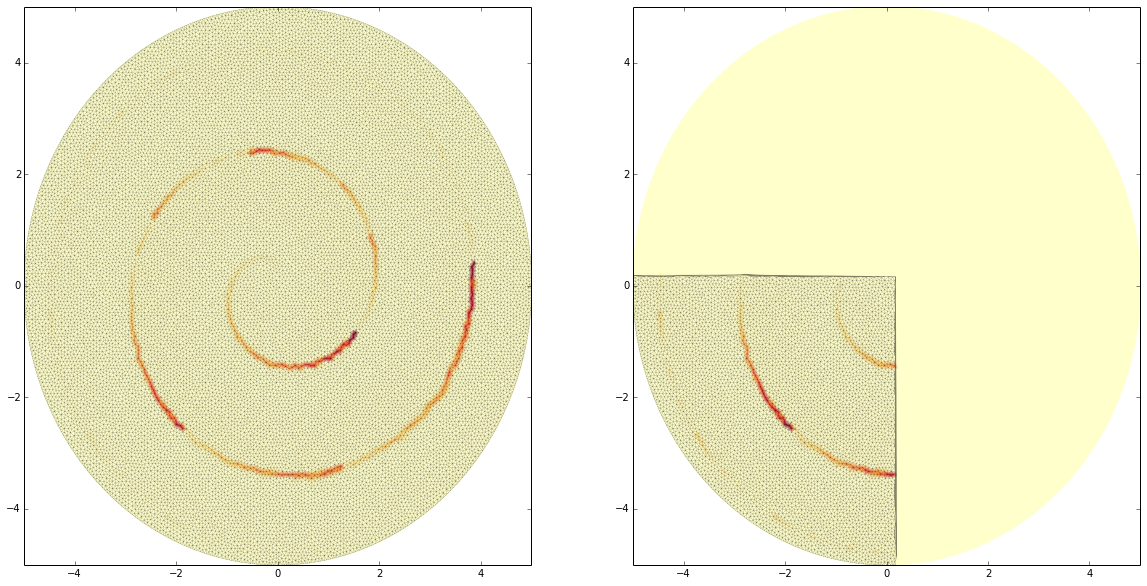

In [14]:
cum0 = mesh5.cumulative_flow(mesh5.area*mesh5.rainfall_pattern)

cum1 = meshQ1s.cumulative_flow(mesh5.area[meshQ1shadow])
cum2 = meshQ1s.cumulative_flow(mesh5.area[meshQ1shadow])
cum3 = meshQ1s.cumulative_flow(mesh5.area[meshQ1shadow])
cum4 = meshQ1s.cumulative_flow(mesh5.area[meshQ1shadow])

cum1p = np.zeros(mesh5.tri.npoints) 
cum1p[meshQ1shadow] = cum1

fig, (plot1,plot2) = plt.subplots(1,2)
fig.set_size_inches(20,10)

lim = 5.0

plot1.set_xlim(-lim, lim)
plot1.set_ylim(-lim, lim)
plot2.set_xlim(-lim, lim)
plot2.set_ylim(-lim, lim)

sm1 = mesh5.add_node_data_to_plot(plot1,cum0, cmap=cm.YlOrRd,  shading="gouraud", alpha=1.0)
sm2 = mesh5.add_node_data_to_plot(plot2,cum1p, cmap=cm.YlOrRd,  shading="gouraud", alpha=1.0)
plot1.triplot(mesh5.x, mesh5.y, mesh5.tri.simplices, color="Black", linewidth=0.25, alpha=0.5)
plot2.triplot(meshQ1s.x, meshQ1s.y, meshQ1s.tri.simplices, color="Black", linewidth=0.25, alpha=0.5)




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


KeyboardInterrupt: 

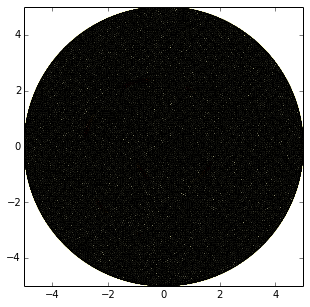

In [76]:
## Make a series of plots to show the flow of information on this mesh

# vector = mesh5.area.copy()

vector = np.ones(mesh5.tri.npoints)

DX0 = vector.copy()
DX1 = vector.copy()

fig, (plot1) = plt.subplots(1,1)
fig.set_size_inches(5,5)

plot1.axes.set_aspect("equal")

lim = 5.0
plot1.set_xlim(-lim, lim)
plot1.set_ylim(-lim, lim)

step=0
while DX1.any() and step < 100: 
    print step
    
    plot1.triplot(mesh5.x, mesh5.y, mesh5.tri.simplices, color="Black", linewidth=0.1, alpha=0.5, zorder=1)
    sm1 = mesh5.add_node_data_to_plot(plot1, DX1, cmap=cm.YlOrRd, vmin=0.0, vmax=1.0, shading="gouraud", alpha=1.0, zorder=0)
    fig.savefig("SpiralInfoPropagation.{:03d}.png".format(step), dpi=300)
    step += 1
    
    DX1 = mesh5.downhillMat.dot(DX1)
    DX0 += DX1    


## Determine the erosion / deposition for this mesh





In [16]:
# %%prun -s cumulative -q -T prunErosionDeposition

# Test the time evolution with a mid-point method

import time as systime

kappa = 1.0e-3
critical_slope = 2.0      # Critical value - assume slides etc take over to limit slope
lowest_slope   = 1.0e-3   # The slope where we cut off the erosion / deposition algorithm
base = 0.0
totalSteps = 0

mesh5.verbose = False

typical_l = np.sqrt(mesh5.area)

# Reset the height

reset = False

if reset:
    totalSteps = 0
    h5 = np.exp(-0.025*(x5**2 + y5**2)**2) + 0.001 * np.random.rand(len(x5))
    mesh5.rainfall_pattern = h5**2  # say !
    mesh5.rainfall_pattern[ mesh5.x > 0] *= ( 1.0 - mesh5.x[ mesh5.x > 0] * 0.2 )**3
    mesh5.update_height(h5)
    mesh5.update_surface_processes()
    


time = 0.0
viz_time= 0.0
vizzes = 0

running_average_uparea = mesh5.cumulative_flow(mesh5.area * mesh5.rainfall_pattern)

for step in range(100,1000):
    totalSteps += 1
    walltime = systime.clock()
    
    delta = h5-mesh5.height
    efficiency = 0.01 # + np.where(delta < -0.00, 0.01, 0.0)
  
    # Erosion + deposition
    
    erosion_rate, deposition_rate, stream_power = \
         mesh5.stream_power_erosion_deposition_rate2(efficiency=efficiency, 
                                                    smooth_power=1, 
                                                    smooth_low_points=0, 
                                                    smooth_erosion_rate=0, 
                                                    smooth_deposition_rate=2, 
                                                    smooth_operator=mesh5.downhill_smoothing,
                                                    centre_weight_u=0.666, centre_weight=0.75)

        
    # Smooth deposition in flat areas ... perhaps this could be replaced by multiple pathways in 
    # flat areas.
    
    erosion_deposition_rate = erosion_rate - deposition_rate
    erosion_timestep    = ((mesh5.slope + lowest_slope) * typical_l / (np.abs(erosion_rate)+0.000001)).min()
    deposition_timestep = ((mesh5.slope + lowest_slope) * typical_l / (np.abs(deposition_rate)+0.000001)).min()
         
    # Diffusion
        
    diffDz, diff_timestep =  mesh5.landscape_diffusion_critical_slope(kappa, critical_slope, True)
        
    ## Mid-point method. Update the height and use this to estimate the new rates of 
    ## Change. Note that we have to assume that the flow pattern doesn't change for this 
    ## to work. This means we can't call the methods which do a full update !
    
    timestep = min(erosion_timestep, deposition_timestep, diff_timestep)
    time = time + timestep
    viz_time = viz_time + timestep

    # Height predictor step (at half time)
    
    height0 = mesh5.height.copy()
    mesh5.height -= 0.5 * timestep * (erosion_deposition_rate - diffDz )
    mesh5.height = np.clip(mesh5.height, base, 1.0e9)   
    
    # Deal with internal drainages !
    mesh5.height = mesh5.handle_low_points2(base, 10)  
    gradZx, gradZy = mesh5.delaunay_grad(mesh5.height)
    mesh5.slope = np.sqrt(gradZx**2+gradZy**2)   
    
    # Recalculate based on mid-point values
    
    erosion_rate, deposition_rate, stream_power = \
         mesh5.stream_power_erosion_deposition_rate2(efficiency=efficiency, 
                                                    smooth_power=1, 
                                                    smooth_low_points=0, 
                                                    smooth_erosion_rate=0, 
                                                    smooth_deposition_rate=2, 
                                                    smooth_operator=mesh5.downhill_smoothing,
                                                    centre_weight_u=0.666, centre_weight=0.75)
        
        
    # Smooth deposition in flat areas ...
             
    erosion_deposition_rate = erosion_rate - deposition_rate
    erosion_timestep    = ((mesh5.slope + lowest_slope) * typical_l / (np.abs(erosion_rate)+0.000001)).min()
    deposition_timestep = ((mesh5.slope + lowest_slope) * typical_l / (np.abs(deposition_rate)+0.000001)).min()
   
    diffDz, diff_timestep =  mesh5.landscape_diffusion_critical_slope(kappa, critical_slope, True)
 
    timestep = min(erosion_timestep, deposition_timestep, diff_timestep)
    
    # Now take the full timestep

    height0 -= timestep * (erosion_deposition_rate - diffDz )
    mesh5.height = np.clip(height0, base, 1.0e9)  
    mesh5.height = mesh5.handle_low_points2(base, 5)

    mesh5.update_height(mesh5.height)
    mesh5.update_surface_processes()
    
    running_average_uparea = 0.5 * running_average_uparea + 0.5 * mesh5.cumulative_flow(mesh5.area * mesh5.rainfall_pattern)


    
    if step%10 == 0:
        print "{:04d} - ".format(step), \
          " dt - {:.5f} ({:.5f}, {:.5f}, {:.5f})".format(timestep, diff_timestep, erosion_timestep, deposition_timestep), \
          " time - {:.4f}".format(time), \
          " Max slope - {:.3f}".format(mesh5.slope.max()), \
          " Step walltime - {:.3f}".format(systime.clock()-walltime)
            
        # print low_point_report
              
    # Store data
    
    if( viz_time > 0.01 or step==0):

        viz_time = 0.0
        vizzes = vizzes + 1

        delta = h5-mesh5.height
        smoothHeight = mesh5.local_area_smoothing(mesh5.height, its=2, centre_weight=0.75)
              
        mesh5.dump_to_file("Spiral.{:04d}".format(vizzes), delta=delta, 
                            uparea=running_average_uparea, erosion=erosion_deposition_rate)

 

0100 -   dt - 0.00016 (0.00500, 0.00075, 0.00016)  time - 0.0003  Max slope - 7.683  Step walltime - 0.912
0110 -   dt - 0.00030 (0.00500, 0.00085, 0.00030)  time - 0.0025  Max slope - 7.682  Step walltime - 0.852
0120 -   dt - 0.00018 (0.00500, 0.00144, 0.00018)  time - 0.0045  Max slope - 7.681  Step walltime - 0.854
0130 -   dt - 0.00007 (0.00500, 0.00047, 0.00007)  time - 0.0060  Max slope - 7.680  Step walltime - 0.892
0140 -   dt - 0.00015 (0.00500, 0.00161, 0.00015)  time - 0.0077  Max slope - 7.680  Step walltime - 0.877
0150 -   dt - 0.00035 (0.00500, 0.00060, 0.00035)  time - 0.0101  Max slope - 7.679  Step walltime - 1.164
0160 -   dt - 0.00008 (0.00500, 0.00063, 0.00008)  time - 0.0124  Max slope - 7.678  Step walltime - 1.029
0170 -   dt - 0.00010 (0.00500, 0.00061, 0.00010)  time - 0.0133  Max slope - 7.677  Step walltime - 1.288
0180 -   dt - 0.00004 (0.00500, 0.00149, 0.00004)  time - 0.0147  Max slope - 7.676  Step walltime - 0.917
0190 -   dt - 0.00010 (0.00500, 0.001

KeyboardInterrupt: 

In [16]:
ls -trl *.*npz |tail -5


-rw-r--r--@ 1 lmoresi  staff   1285078  6 Apr 10:54 Spiral.0007.npz
-rw-r--r--@ 1 lmoresi  staff   1285078  6 Apr 10:54 Spiral.0008.npz
-rw-r--r--@ 1 lmoresi  staff   2236905  6 Apr 12:56 MyNewMesh.npz
-rw-r--r--@ 1 lmoresi  staff   1468407  6 Apr 13:13 Spiral.0001.npz
-rw-r--r--@ 1 lmoresi  staff   1468407  6 Apr 13:13 Spiral.0002.npz
